# EPG Benchmark

We will compare accuracy and runtime with [Sycomore](https://sycomore.readthedocs.io/en/latest/epg/index.html) and [mri-sim-py](https://github.com/utcsilab/mri-sim-py). We will simulate a Fast Spin Echo acquisition for Myelin Water Fraction mapping (with and without exchange between myelin water and free water).

First, we define some utilities to plot signals:

In [1]:
%matplotlib inline
        
import numpy as np
import matplotlib.pyplot as plt

# plotting
def display_signal(input, legend=None, symbol='-', color=None):
    if color is not None:
        plt.gca().set_prop_cycle(plt.cycler("color", color))
    plt.plot(abs(input), symbol)
    plt.xlim([0, len(input)])
    plt.xlabel("Echo index")
    plt.ylabel("signal magnitude [a.u.]")
    if legend is not None:
        plt.legend(legend)
    plt.tight_layout()

## Reference implementation

Reference implementations of using [mri-sim-py](mri-sim-py](https://github.com/utcsilab/mri-sim-py) (Pytorch backend, GPU-accelerated, no exchange, magnetization transfer or flow) and [Sycomore](https://sycomore.readthedocs.io/en/latest/epg/index.html) (C++ backend, CPU-only, not parallelized across multiple atoms, accounts for exchange, magnetization transfer and flow).

In [2]:
# load ground truth EPG-X data
import scipy

ground_truth = scipy.io.loadmat("notebooks/epgxsignal.mat")
sig0noex = ground_truth["s0"].squeeze() 
sig0ex = ground_truth["s"].squeeze() 

In [3]:
# mri-sim-py implementation
import time

import torch

import mrisimpy as simpy

def mrisimpy_fse(flip, ESP, T1, T2, device="cpu", verbose=False):
    
    # sequence parameters
    flip = torch.as_tensor(flip, dtype=torch.float32, device=device)
    flip = torch.deg2rad(flip)

    # convert to array  
    T1 = torch.atleast_1d(torch.as_tensor(T1, dtype=torch.float32, device=device)) 
    T2 = torch.atleast_1d(torch.as_tensor(T2, dtype=torch.float32, device=device))
    
    # broadcast
    T1, T2 = torch.broadcast_tensors(T1, T2)

   # do computation
    t0 = time.time()
    signal = simpy.FSE_signal(flip[None,:], ESP, T1, T2).squeeze()
    t1 = time.time()

    if verbose:
        return signal.detach().cpu().numpy(), t1-t0
    else:
        return signal.detach().cpu().numpy()


In [4]:
# Sycomore implementation
import multiprocess as mp

import sycomore
from sycomore.units import *

def _sycomore_fse(flip, ESP, T1, T2, T1b=None, T2b=None, k=None, fb=None):
    # parse 
    npulses = flip.shape[0]
    
    # initialize spin system
    if T1b is None:
        species = sycomore.Species(T1, T2)

        # initialize model
        model = sycomore.epg.Regular(species)
    else:
        species_a = sycomore.Species(T1, T2)
        species_b = sycomore.Species(T1b, T2b)
        M0a = np.asarray([0.0, 0.0, 1-fb], dtype=np.float64)
        M0b = np.asarray([0.0, 0.0, fb], dtype=np.float64)
        k_a = k * fb

        # initialize model
        model = sycomore.epg.Regular(species_a, species_b, M0a, M0b, k_a)
    
    # initialize output
    signal = np.zeros(npulses, dtype=np.complex64)

    # excitation
    model.apply_pulse(90.0 * deg)
    
    # loop over flip angles
    for n in range(npulses):
        
        # apply relaxation
        model.relaxation(0.5 * ESP)

        # shift states
        model.shift()
        
        # apply rf
        model.apply_pulse(flip[n])

        # shift states
        model.shift()

        # apply relaxation
        model.relaxation(0.5 * ESP)

        # record signal
        signal[n] = model.echo

    return signal
    
def sycomore_fse(flip, ESP, T1, T2, T1b=None, T2b=None, k=None, fb=None, verbose=False, parallel=False):

    # sequence parameters
    flip = np.asarray(flip) * deg
    ESP = ESP * ms

    # convert to array  
    T1 = np.atleast_1d(np.asarray(T1)) 
    T2 = np.atleast_1d(np.asarray(T2))

    if T1b is not None:
        T1b = np.atleast_1d(np.asarray(T1b)) 
        T2b = np.atleast_1d(np.asarray(T2b))
        k = np.atleast_1d(np.asarray(k))
        fb = np.atleast_1d(np.asarray(fb))
        
    # broadcast
    if T1b is None:
        T1, T2 = np.broadcast_arrays(T1, T2)
    else:
        T1, T2, T1b, T2b, k, fb = np.broadcast_arrays(T1, T2, T1b, T2b, k, fb)

    # units
    T1 = T1 * ms
    T2 = T2 * ms

    if T1b is not None:
        T1b = T1b * ms
        T2b = T2b * ms
        k = k * Hz

    # get natoms
    natoms = T1.shape[0]
    
    # run
    if parallel is False:
        engine = _sycomore_fse
        t0 = time.time()
        if T1b is None:
            signal = [engine(flip, ESP, T1[n], T2[n]) for n in range(natoms)]
        else:
            signal = [engine(flip, ESP, T1[n], T2[n], T1b[n], T2b[n], k[n], fb[n]) for n in range(natoms)]
        t1 = time.time()
        if verbose:
            return np.stack(signal, axis=0).squeeze(), t1-t0
        else:
            return np.stack(signal, axis=0).squeeze()
    else:
        if T1b is None:
            engine = lambda t1, t2 : _sycomore_fse(flip, ESP, t1, t2)
        else:
            engine = lambda t1, t2, t1b, t2b, kk, ff : _sycomore_fse(flip, ESP, t1, t2, t1b, t2b, kk, ff)
        t0 = time.time()
        if T1b is None:
            with mp.Pool(mp.cpu_count()) as p:
                signal = p.starmap(engine, zip(T1, T2))
        else:
            with mp.Pool(mp.cpu_count()) as p:
                signal = p.starmap(engine, zip(T1, T2, T1b, T2b, k, fb))
        t1 = time.time()
        if verbose:
            return np.stack(signal, axis=0), t1-t0
        else:
            return np.stack(signal, axis=0)
        

## Validation

In [5]:
import epgtorchx as epgx

# parameters
flip = 50 * [180.0]
phases = 50 * [90.0]
ESP = 5.0

T1 = 1000.0 # [500.0, 833.0, 2569.0]
T2 = 100.0  # 

T1b = 500.0 # ms 
T2b = 20.0 # ms 

f = 0.2
k = 10.0 # Hz  

# computation
signoex = epgx.fse(flip, phases, ESP, T1, T2, T1bm=T1b, T2bm=T2b, kbm=0.0, weight_bm=f)
sigex = epgx.fse(flip, phases, ESP, T1, T2, T1bm=T1b, T2bm=T2b, kbm=k, weight_bm=f)

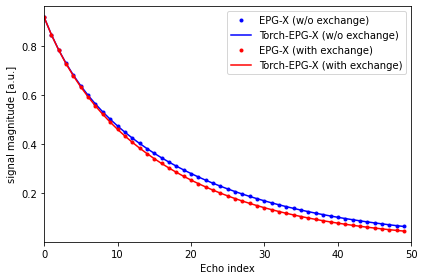

In [6]:
legend = ["EPG-X (w/o exchange)", "Torch-EPG-X (w/o exchange)", "EPG-X (with exchange)", "Torch-EPG-X (with exchange)"]
display_signal(sig0noex.T, color=["b"], symbol='.'),
display_signal(signoex.T, color=["b"], symbol='-'),
display_signal(sig0ex.T, color=["r"], symbol='.'), 
display_signal(sigex.T, color=["r"], symbol='-', legend=legend)

## Benchmark

In [7]:
# define grid of values
batchsizes = np.linspace(1, 100000, 21).astype(int).tolist()

# preallocate runtimes
t_sycomore_serial = []
t_sycomore_parallel = [] 
t_mrsimpy_cpu = [] 
t_mrsimpy_gpu = [] 
t_epgtorchx_cpu = [] 
t_epgtorchx_gpu = [] 

t_sycomore_serial_ex = []
t_sycomore_parallel_ex = []
t_epgtorchx_cpu_ex = [] 
t_epgtorchx_gpu_ex = [] 

# no-exchange case
for b in batchsizes:
    T = T1 * np.ones(b, dtype=np.float32)
    
    _, tmp = sycomore_fse(flip, ESP, T, T2, verbose=True) 
    t_sycomore_serial.append(tmp)
    _, tmp = sycomore_fse(flip, ESP, T, T2, verbose=True, parallel=True)
    t_sycomore_parallel.append(tmp)
    _, tmp = mrisimpy_fse(flip, ESP, T, T2, verbose=True) 
    t_mrsimpy_cpu.append(tmp)
    _, tmp = mrisimpy_fse(flip, ESP, T, T2, verbose=True, device="cuda:0") 
    t_mrsimpy_gpu.append(tmp)
    _, tmp = epgx.fse(flip, phases, ESP, T, T2, verbose=True)
    t_epgtorchx_cpu.append(tmp)
    _, tmp = epgx.fse(flip, phases, ESP, T, T2, verbose=True, device="cuda:0") 
    t_epgtorchx_gpu.append(tmp)
    
    _, tmp = sycomore_fse(flip, ESP, T, T2, T1b=T1b, T2b=T2b, k=k, fb=f, verbose=True) 
    t_sycomore_serial_ex.append(tmp)
    _, tmp = sycomore_fse(flip, ESP, T, T2, T1b=T1b, T2b=T2b, k=k, fb=f, verbose=True, parallel=True)
    t_sycomore_parallel_ex.append(tmp)
    _, tmp = epgx.fse(flip, phases, ESP, T, T2, T1bm=T1b, T2bm=T2b, kbm=k, weight_bm=f, verbose=True)
    t_epgtorchx_cpu_ex.append(tmp)
    _, tmp = epgx.fse(flip, phases, ESP, T, T2, T1bm=T1b, T2bm=T2b, kbm=k, weight_bm=f, verbose=True, device="cuda:0") 
    t_epgtorchx_gpu_ex.append(tmp)

# turn into numpy arrays for plot
t_sycomore_serial = np.asarray(t_sycomore_serial)
t_sycomore_parallel = np.asarray(t_sycomore_parallel)
t_mrsimpy_cpu = np.asarray(t_mrsimpy_cpu)
t_mrsimpy_gpu = np.asarray(t_mrsimpy_gpu)
t_epgtorchx_cpu = np.asarray(t_epgtorchx_cpu)
t_epgtorchx_gpu = np.asarray(t_epgtorchx_gpu)
t_sycomore_serial_ex = np.asarray(t_sycomore_serial_ex)
t_sycomore_parallel_ex = np.asarray(t_sycomore_parallel_ex)
t_epgtorchx_cpu_ex = np.asarray(t_epgtorchx_cpu_ex)
t_epgtorchx_gpu_ex = np.asarray(t_epgtorchx_gpu_ex)


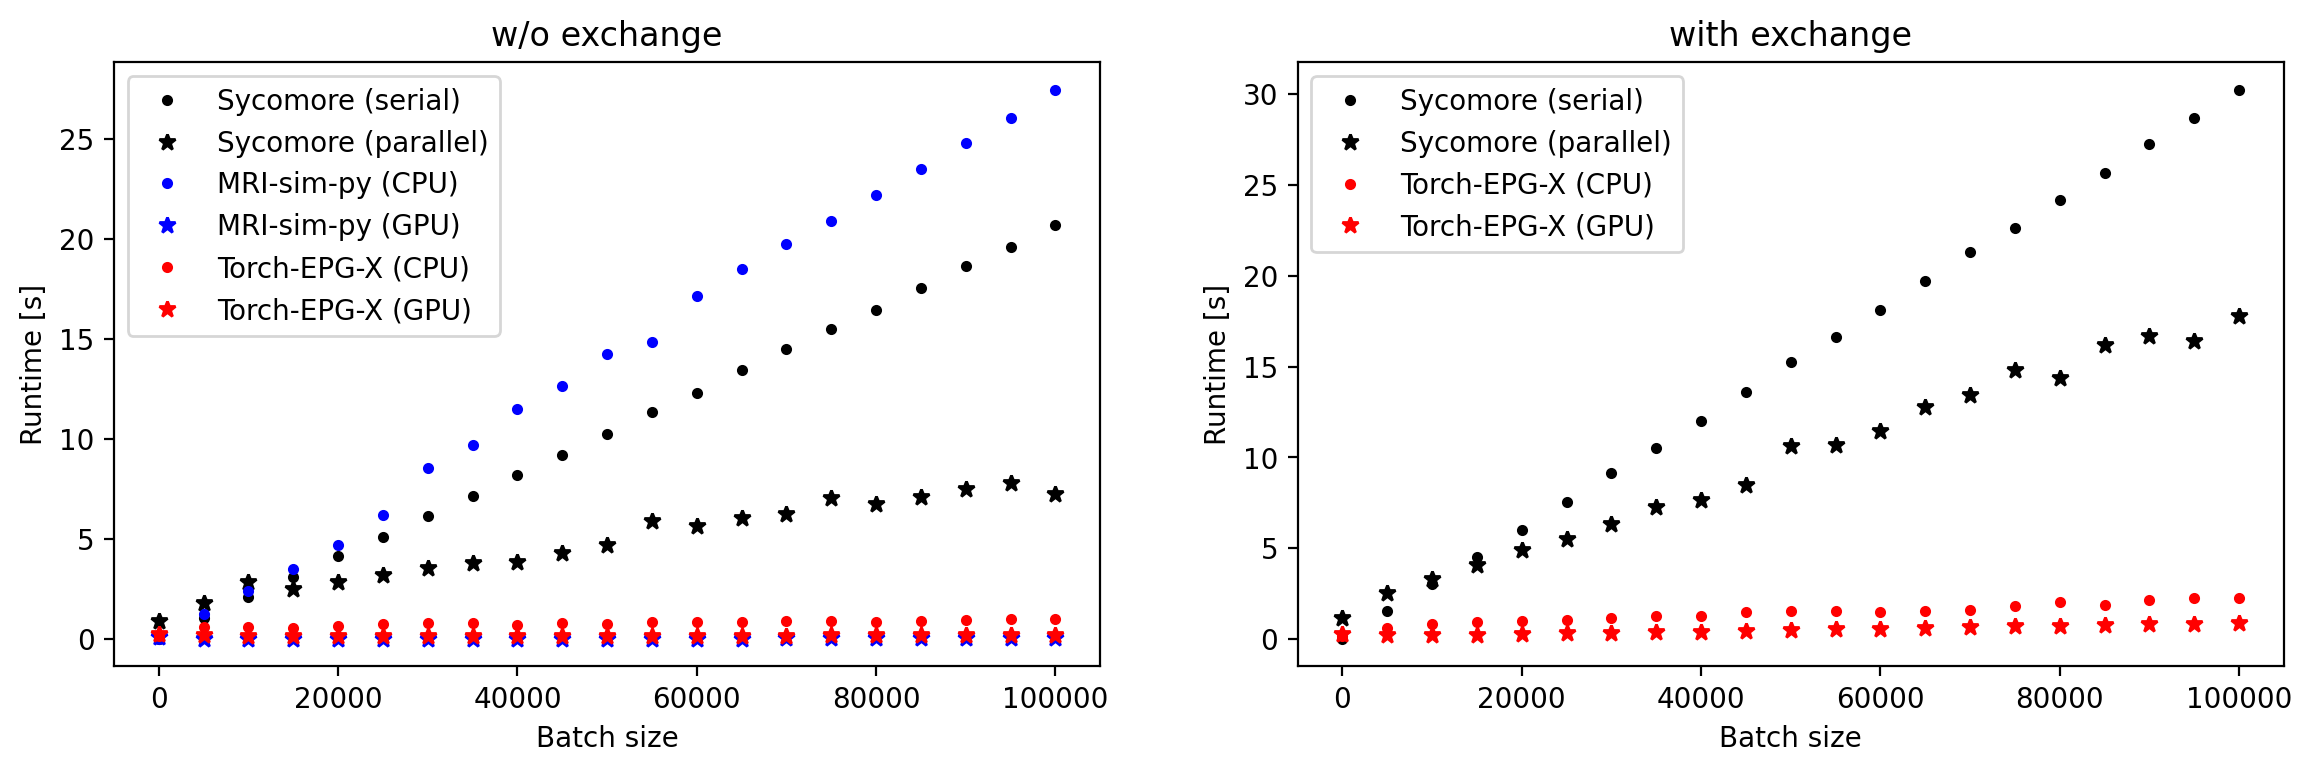

In [8]:
# define labels
labels1 = ["Sycomore (serial)", "Sycomore (parallel)", "MRI-sim-py (CPU)", "MRI-sim-py (GPU)", "Torch-EPG-X (CPU)", "Torch-EPG-X (GPU)"]
labels2 = ["Sycomore (serial)", "Sycomore (parallel)", "Torch-EPG-X (CPU)", "Torch-EPG-X (GPU)"]

batchsizes_arr = np.asarray(batchsizes)

plt.rcParams['figure.figsize'] = [14, 4]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
plt.subplot(1,2,1)
plt.plot(batchsizes_arr, t_sycomore_serial, '.k')
plt.plot(batchsizes_arr, t_sycomore_parallel, '*k')
plt.plot(batchsizes_arr, t_mrsimpy_cpu, '.b')
plt.plot(batchsizes_arr, t_mrsimpy_gpu, '*b')
plt.plot(batchsizes_arr, t_epgtorchx_cpu, '.r')
plt.plot(batchsizes_arr, t_epgtorchx_gpu, '*r')
plt.title("w/o exchange")
plt.xlabel("Batch size")
plt.ylabel("Runtime [s]")
plt.legend(labels1)
plt.subplot(1,2,2)
plt.title("with exchange")
plt.plot(batchsizes_arr, t_sycomore_serial_ex, '.k')
plt.plot(batchsizes_arr, t_sycomore_parallel_ex, '*k')
plt.plot(batchsizes_arr, t_epgtorchx_cpu_ex, '.r')
plt.plot(batchsizes_arr, t_epgtorchx_gpu_ex, '*r')
plt.xlabel("Batch size")
plt.ylabel("Runtime [s]")
plt.legend(labels2)